# Ankle Power Analysis

In [1]:
%matplotlib widget

In [2]:
# import libraries
import pandas as pd
import numpy as np
from scipy import signal
from scipy.fft import fft, ifft,fftfreq

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm, trange

# Defining functions

In [3]:
def quartion_to_euler_angles(quaternion):
    q = np.array([quaternion[:,0],quaternion[:,1],quaternion[:,2],quaternion[:,3]])
    # Euler angles:
    ## roll (x-axis rotation)
    t0 = 2 * (q[0] * q[1] + q[2] * q[3])
    t1 = 1 - 2 * (q[1] * q[1] + q[2] * q[2])
    roll_phi = np.arctan2(t0, t1)
    ## pitch (y-axis rotation)
    t2 = 2 * (q[0] * q[2] - q[3] * q[1])
    t2 = np.where(t2>1,1,t2)
    t2 = np.where(t2<-1, -1, t2)
    pitch_theta = np.arcsin(t2)
    ## yaw (z-axis rotation)
    t3 = +2.0 * (q[0] * q[3] + q[1] * q[2])
    t4 = +1.0 - 2.0 * (q[2] * q[2] + q[3] * q[3])
    yaw_psi = np.arctan2(t3, t4)
    return [roll_phi, pitch_theta, yaw_psi]

def rotation_matrix_from_euler_angles(roll_phi, pitch_theta, yaw_psi):
    ## Cos and sin of angles:
    cos_phi = np.cos(roll_phi)
    cos_theta = np.cos(pitch_theta)
    cos_psi = np.cos(yaw_psi)
    sin_phi = np.sin(roll_phi)
    sin_theta = np.sin(pitch_theta)
    sin_psi = np.sin(yaw_psi)
    ## Matrix values:
    i_11 = cos_theta * cos_psi
    i_12 = -cos_phi * sin_psi + sin_phi * sin_theta * cos_psi
    i_13 = sin_phi * sin_psi + cos_phi * sin_theta * cos_psi
    i_21 = cos_theta*sin_psi
    i_22 = cos_phi * cos_psi + sin_phi * sin_theta * sin_psi
    i_23 = -sin_phi * cos_psi + cos_phi * sin_theta * sin_psi
    i_31 = -sin_theta
    i_32 = sin_phi * cos_theta
    i_33 = cos_phi * cos_theta
    # Rotation matrix:
    rotation_matrix = np.array([[i_11, i_12, i_13],
                                 [i_21, i_22, i_23],
                                 [i_31, i_32, i_33]])
    return rotation_matrix

def speed_rotation(rotation_matrix,speed):
    speed_rot = np.zeros((len(speed), 3))
    ran =len(speed)
    for i in trange((ran), desc="Speed rotation"):
        # Multiplication of each rotation matrix with the corresponding speed
        speed_rot[i] = np.matmul(rotation_matrix[:,:,i],speed[i]) 
    return speed_rot

def acceleration_from_speed(speed_rot,time_d):
    # Acceleration = (v_i+1 - v_i) / (t_i+1 - t_i)
    acceleration = np.diff(speed_rot,axis=0) / np.diff(time_d)[:,None]
    return acceleration

def power_from_speed_acceleration(speed_rot,acceleration):
    # Dot product between acceleration and speed
    power = np.sum(speed_rot[1:]*acceleration, axis=1)
    return power

def butterworth_filter(day_time,fc,degree,speed_rot,type='lowpass'):
    T = day_time[1]
    # Filter definition
    sos = signal.butter(degree, fc, type, fs=1/T, output='sos')
    # Signal filtration
    filtered_x = signal.sosfilt(sos, speed_rot[:,0])
    filtered_y = signal.sosfilt(sos, speed_rot[:,1])
    filtered_z = signal.sosfilt(sos, speed_rot[:,2])
    return np.array([filtered_x, filtered_y,filtered_z]).T

# First analysis of the data
Evaluation of day 1. The other days were also evaluated, but it is not shown.

In [41]:
# Complete the file path
filePath = 'C:/Users/camil/Documents/code/ankle-power/data/'
filename = 'Day_1.npz'

day1 = np.load(filePath + filename)

In [42]:
# Calculation of the rotation matrix from quaternion
euler_angles_1 = quartion_to_euler_angles(day1["quaternion"])
rotation_matrix_1 = rotation_matrix_from_euler_angles(euler_angles_1[0], euler_angles_1[1], euler_angles_1[2])
# Speed ​​rotation
speed_rot_1 = speed_rotation(rotation_matrix_1,day1["speed"])
# Calculating acceleration
acceleration_1 = acceleration_from_speed(speed_rot_1,day1["time"])
# Calculating power
power_1 = power_from_speed_acceleration(speed_rot_1,acceleration_1)

Speed rotation:   0%|          | 0/5569571 [00:00<?, ?it/s]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
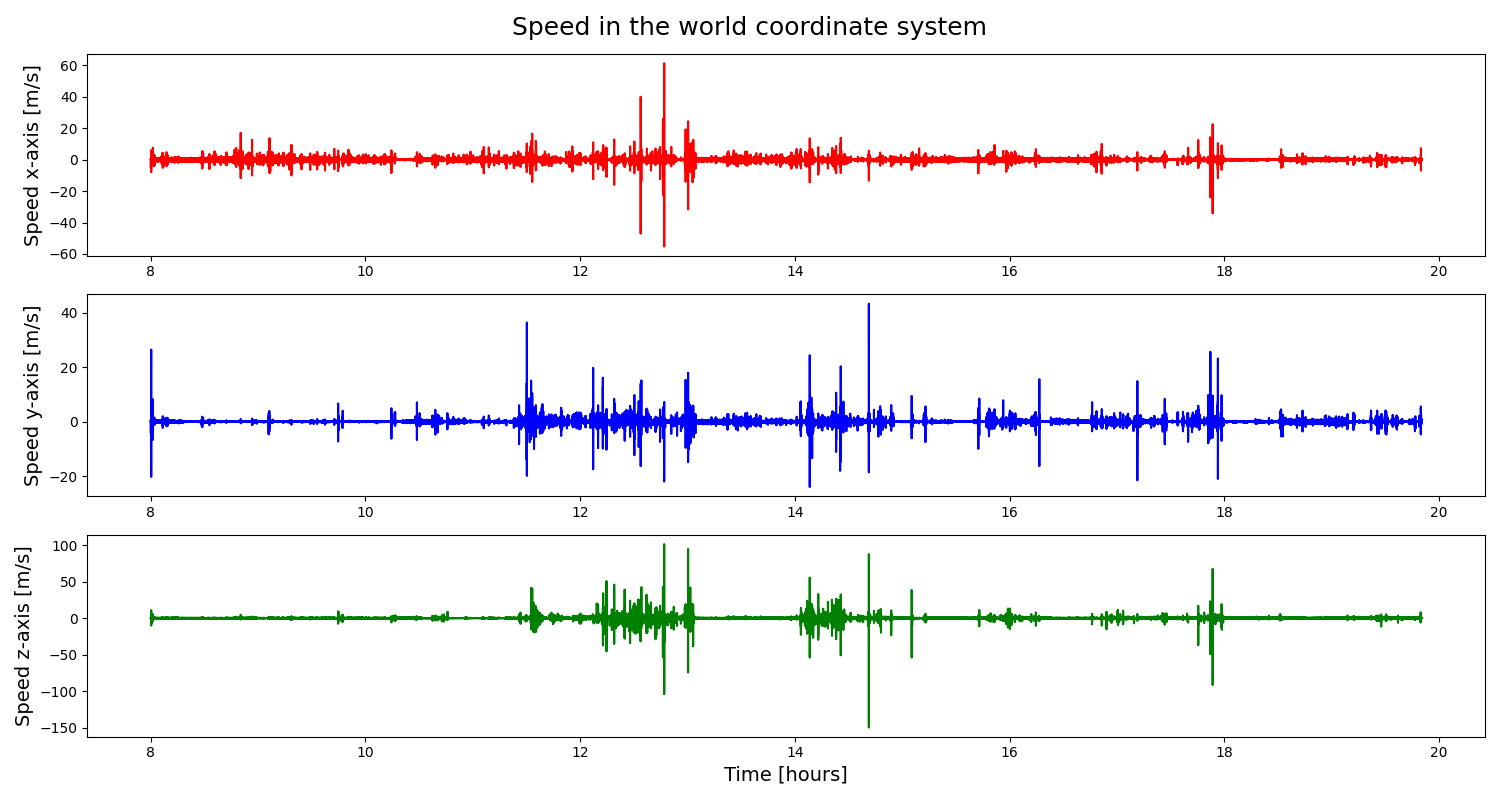

In [43]:
# Graph: Speed in the world coordinate system
plt.close('all')
t=day1["time"]/(3600) + 8 # Converting seconds to hours on the x-axis
fig_speed_rot_1 = plt.figure(figsize=(15,8))
fig_speed_rot_1.suptitle('Speed in the world coordinate system', fontsize=18)
ax1 = fig_speed_rot_1.add_subplot(311)
ax1.plot(t, speed_rot_1[:,0], color='r')
ax1.set_ylabel('Speed x-axis [m/s]', fontsize=14)
ax2 = fig_speed_rot_1.add_subplot(312)
ax2.plot(t, speed_rot_1[:,1], color='b')
ax2.set_ylabel('Speed y-axis [m/s]', fontsize=14)
ax3 = fig_speed_rot_1.add_subplot(313)
ax3.plot(t, speed_rot_1[:,2], color='g')
ax3.set_ylabel('Speed z-axis [m/s]', fontsize=14)
ax3.set_xlabel('Time [hours]', fontsize=14)
plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
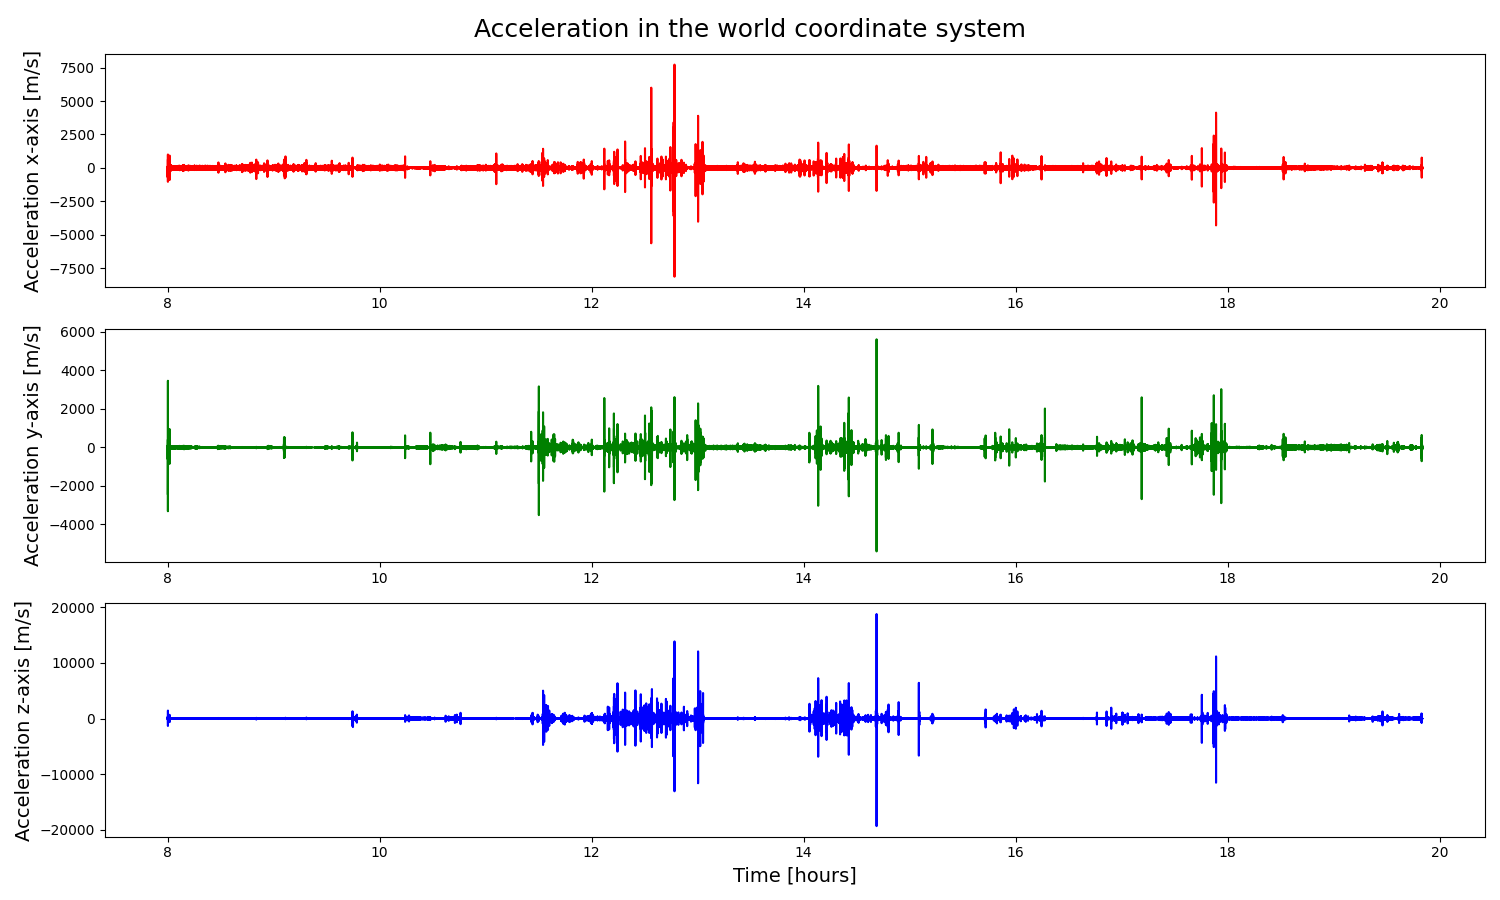

In [44]:
# Graph: Acceleration in the world coordinate system
fig_acce = plt.figure(figsize=(15,9))
fig_acce.suptitle('Acceleration in the world coordinate system', fontsize=18)
ax_1 = fig_acce.add_subplot(311)
ax_1.plot(t[1:], acceleration_1[:,0], color='r')
ax_1.set_ylabel('Acceleration x-axis [m/s]', fontsize=14)
ax_2 = fig_acce.add_subplot(312)
ax_2.plot(t[1:], acceleration_1[:,1], color='g')
ax_2.set_ylabel('Acceleration y-axis [m/s]', fontsize=14)
ax_3 = fig_acce.add_subplot(313)
ax_3.plot(t[1:], acceleration_1[:,2], color='b')
ax_3.set_ylabel('Acceleration z-axis [m/s]', fontsize=14)
ax_3.set_xlabel('Time [hours]', fontsize=14)
plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
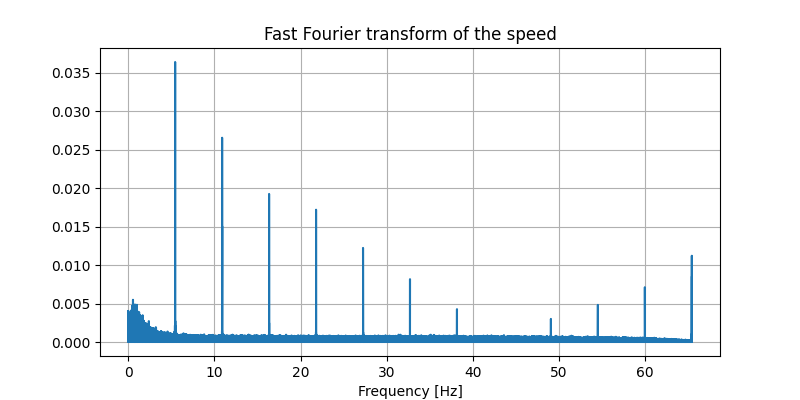

In [45]:
# Fast Fourier transform of the speed (It was evaluated in the three axes)
plt.close('all')
N = len(speed_rot_1[:,0])# Number of sample points
T = day1["time"][1]# sample spacing
x = np.linspace(0.0, N*T, N, endpoint=False)
yf = fft(speed_rot_1[:,2])
xf = fftfreq(N, T)[:N//2]
fig,ax = plt.subplots(figsize=(8,4))
ax.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
ax.set_title('Fast Fourier transform of the speed')
ax.set_xlabel('Frequency [Hz]')
plt.grid()

In [46]:
## Filtering
# Second degree low pass Butterworth filter, with a cutoff frequency of 15 Hz
fc = 10 #cutoff frequency for filtering
degree= 2 # dregree for the filter
speed_rot_filt_1 = butterworth_filter(day1["time"],fc,degree,speed_rot_1,type='lowpass')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
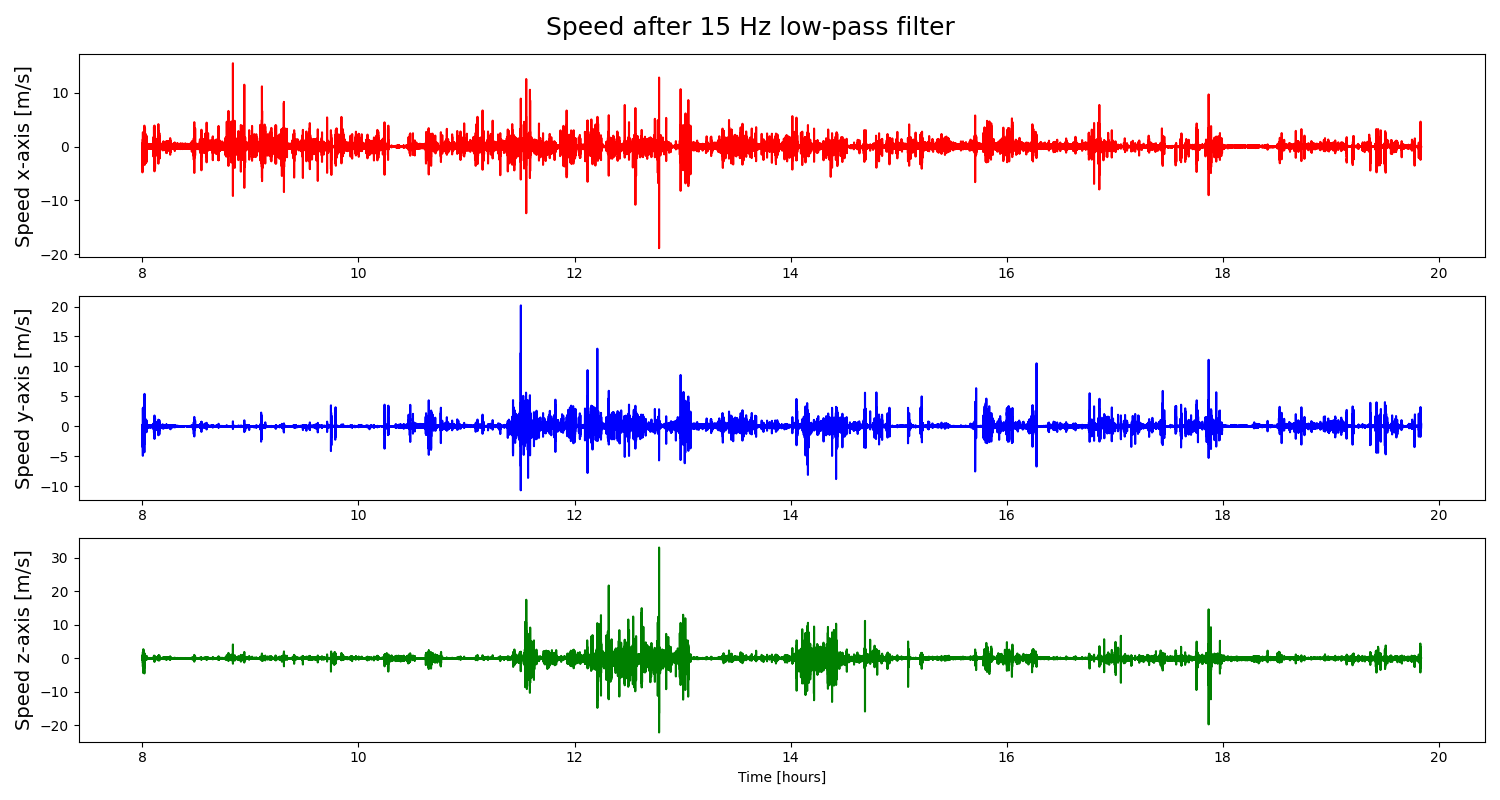

In [47]:
# Graph: Speed after 15 Hz low-pass filter
plt.close('all')
t=day1["time"]/(3600) + 8
fig_speed_filt_1 = plt.figure(figsize=(15,8))
fig_speed_filt_1.suptitle('Speed after 15 Hz low-pass filter', fontsize=18)
ax1 = fig_speed_filt_1.add_subplot(311)
ax1.plot(t, speed_rot_filt_1[:,0], color='r')
ax1.set_ylabel('Speed x-axis [m/s]', fontsize=14)
ax2 = fig_speed_filt_1.add_subplot(312)
ax2.plot(t, speed_rot_filt_1[:,1], color='b')
ax2.set_ylabel('Speed y-axis [m/s]', fontsize=14)
ax3 = fig_speed_filt_1.add_subplot(313)
ax3.plot(t, speed_rot_filt_1[:,2], color='g')
ax3.set_ylabel('Speed z-axis [m/s]', fontsize=14)
ax3.set_xlabel('Time [hours]')
plt.tight_layout()

In [48]:
# Calculation of acceleration from filtered speed
acceleration_1_filt = acceleration_from_speed(speed_rot_filt_1,day1["time"])
# Calculation of power from filtered speed
power_filt_1 = power_from_speed_acceleration(speed_rot_filt_1,acceleration_1_filt)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
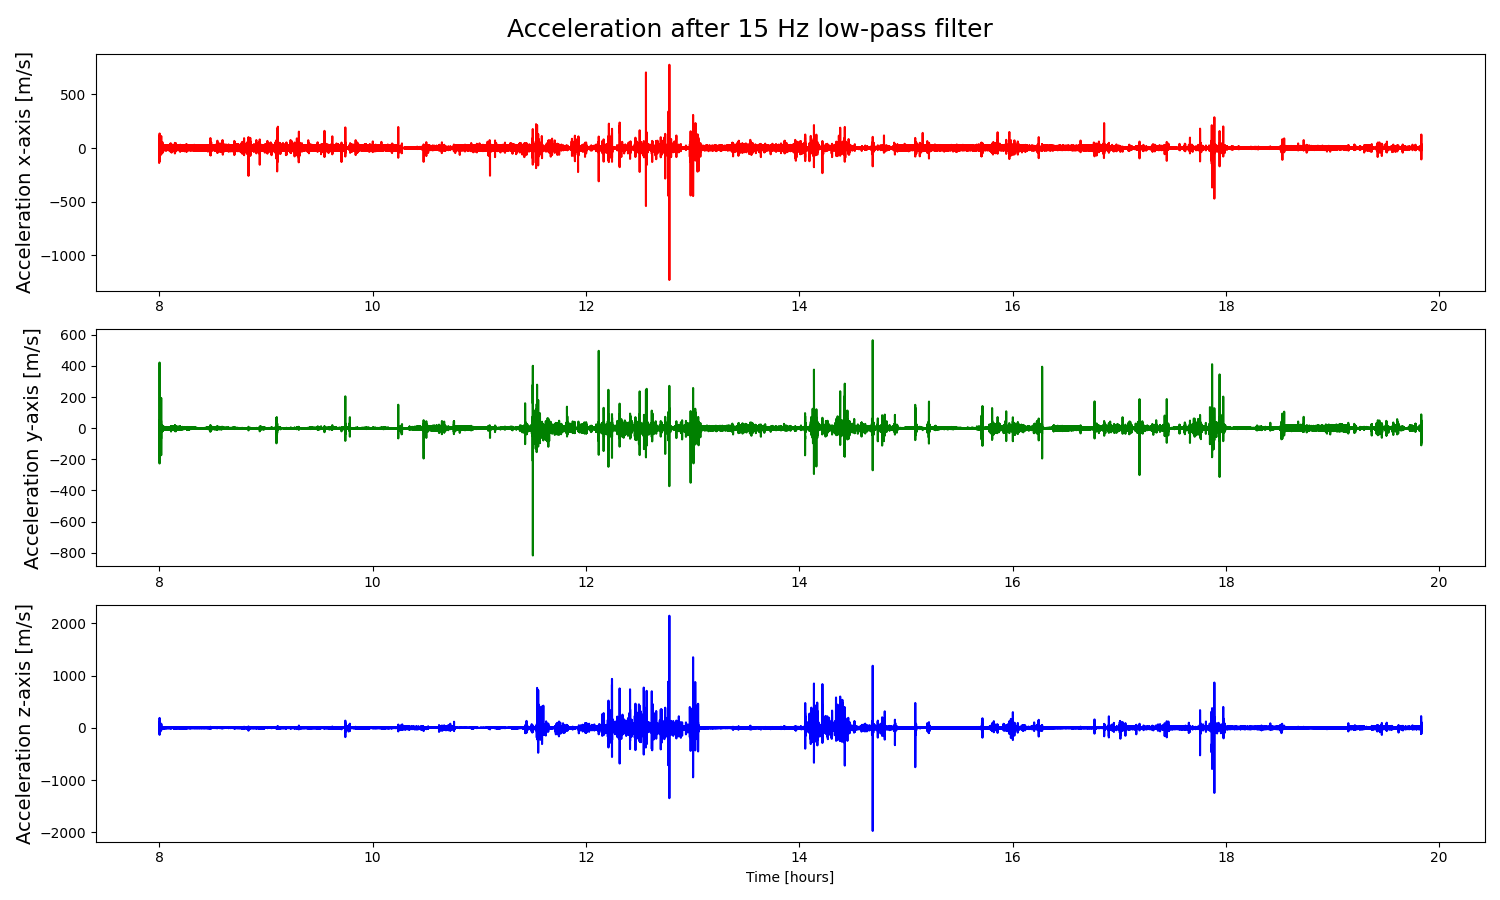

In [49]:
# Graph: Acceleration after 15 Hz low-pass filter
plt.close('all')
fig_acce_filt = plt.figure(figsize=(15,9))
fig_acce_filt.suptitle('Acceleration after 15 Hz low-pass filter', fontsize=18)
ax1 = fig_acce_filt.add_subplot(311)
ax1.plot(t[1:], acceleration_1_filt[:,0], color='r')
ax1.set_ylabel('Acceleration x-axis [m/s]', fontsize=14)
ax2 = fig_acce_filt.add_subplot(312)
ax2.plot(t[1:], acceleration_1_filt[:,1], color='g')
ax2.set_ylabel('Acceleration y-axis [m/s]', fontsize=14)
ax3 = fig_acce_filt.add_subplot(313)
ax3.plot(t[1:], acceleration_1_filt[:,2], color='b')
ax3.set_ylabel('Acceleration z-axis [m/s]', fontsize=14)
ax3.set_xlabel('Time [hours]')
plt.tight_layout()

Text(0, 0.5, 'Power [W/Kg]')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
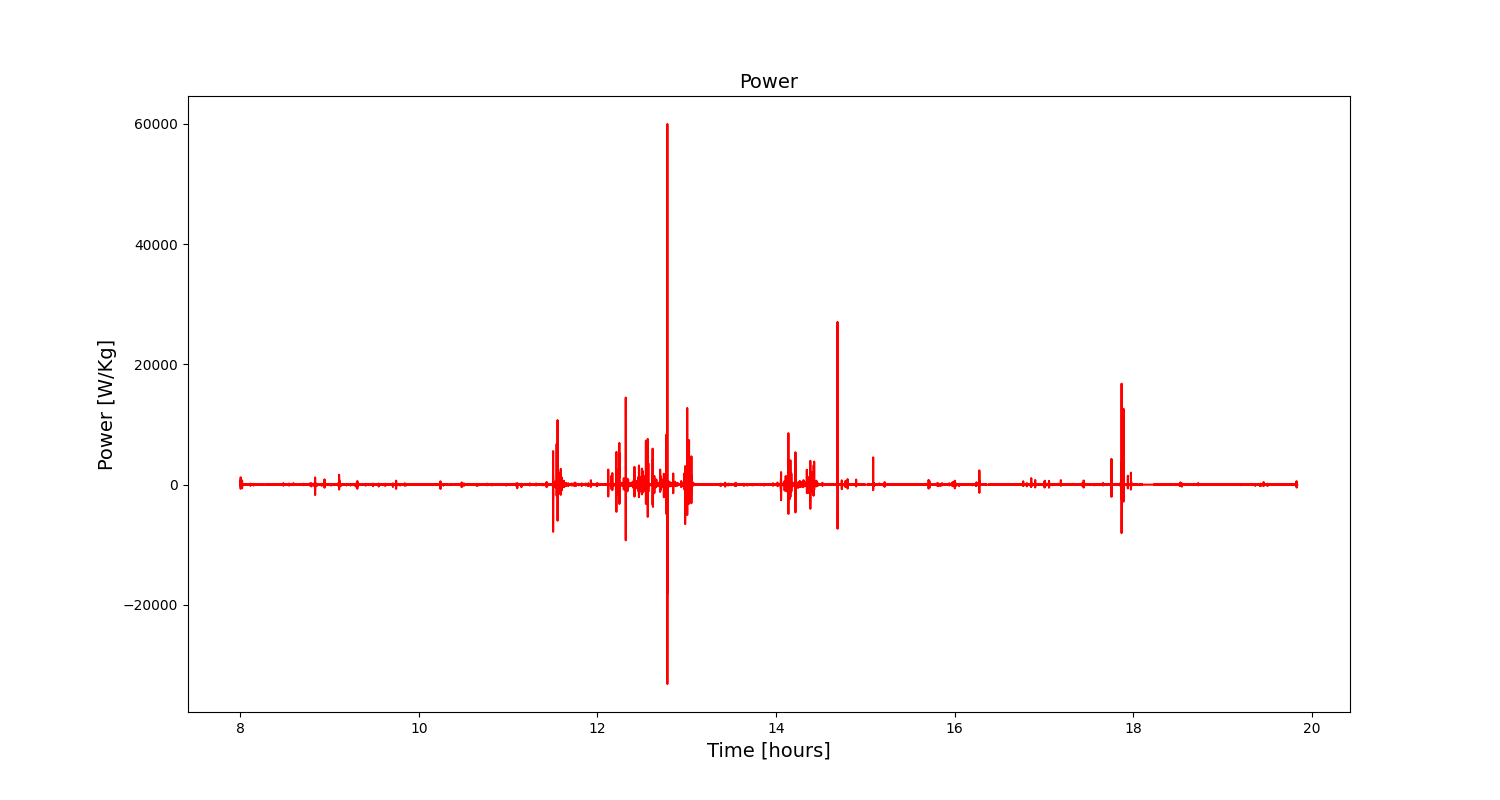

In [50]:
# Graph of the Power
plt.close('all')
fig_power_filt_1 = plt.figure(figsize=(15,8))
ax1 = fig_power_filt_1.add_subplot(111)
ax1.plot(t[1:], power_filt_1, color='r')
ax1.set_title('Power', fontsize=14)
ax1.set_xlabel('Time [hours]', fontsize=14)
ax1.set_ylabel('Power [W/Kg]', fontsize=14)

Text(0, 0.5, 'Power')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
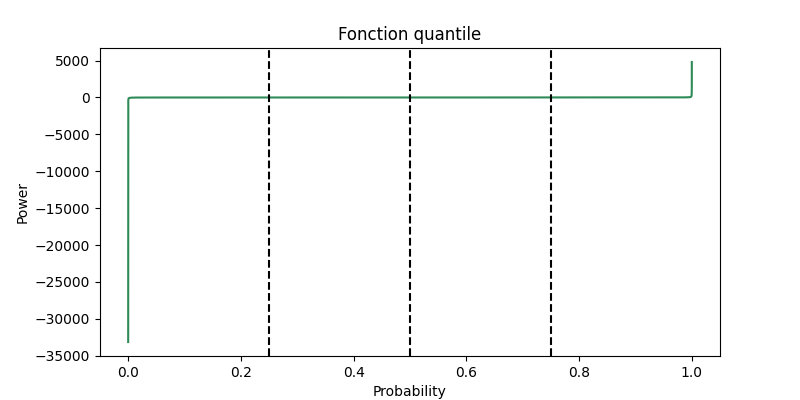

In [51]:
# Graph of the quantile to analyze the distribution of power
Probability = np.arange(0.0, 1.0, 0.00001)
quantile = np.quantile(power_filt_1,Probability)
figz,ax_q=plt.subplots(figsize=(8,4))
sns.lineplot(x=Probability, y=quantile,ax=ax_q,color='seagreen')
plt.axvline(x=0.25, color='k', linestyle='--')
plt.axvline(x=0.5, color='k', linestyle='--')
plt.axvline(x=0.75, color='k', linestyle='--')
ax_q.set_title('Fonction quantile')
ax_q.set_xlabel('Probability')
ax_q.set_ylabel('Power')

In [52]:
# Negative values ​​to zero and values ​​greater than 0.999 quantile (outliers) to zero.
quantile_max = int(np.quantile(power_filt_1,0.999))
power_quantile_1 = np.where(power_filt_1 < quantile_max, power_filt_1, 0)
power_quantile_1 = np.where(power_quantile_1 > 0, power_quantile_1, 0)

In [53]:
# Maximum allowed value for power
quantile_max

126

Text(0, 0.5, 'Power [W/Kg]')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
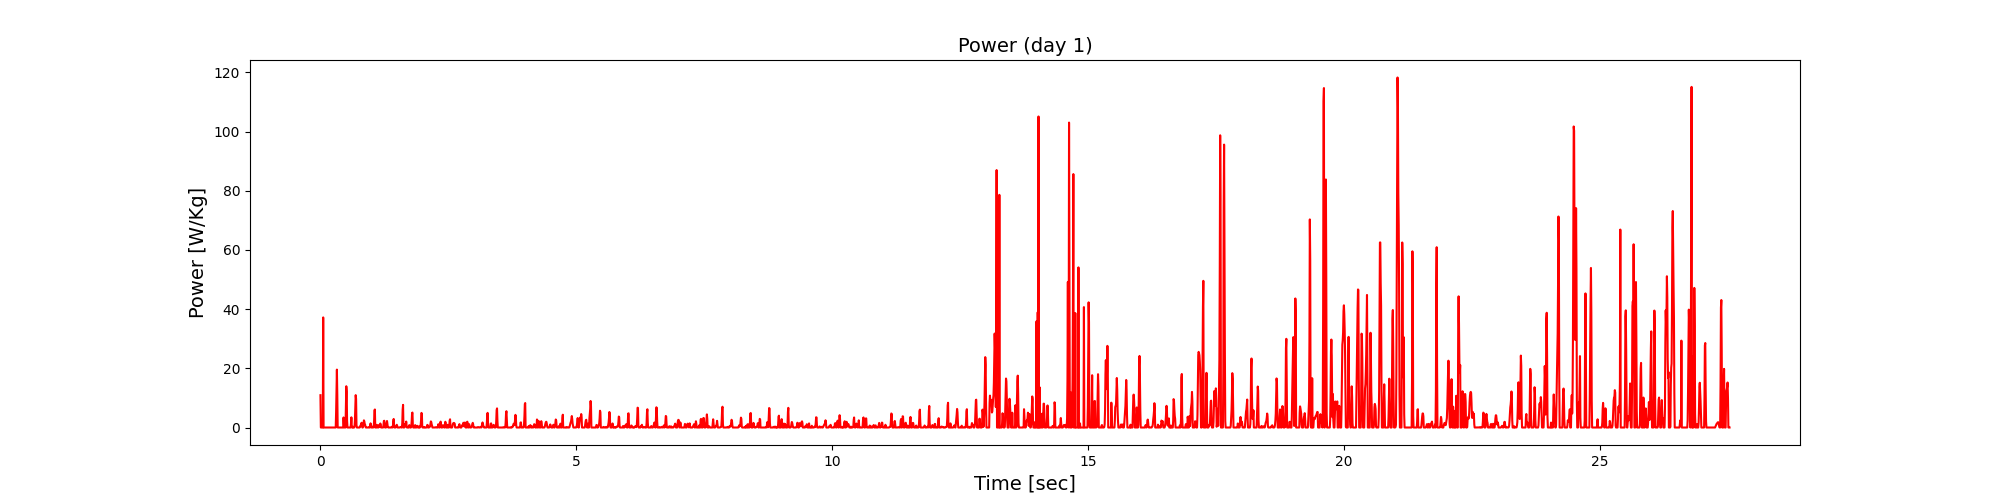

In [54]:
# Graph: Power (30 sec)
a_seg=3600
b_seg=a_seg*1
fig_power_quantile_1 = plt.figure(figsize=(20,5))
ax1 = fig_power_quantile_1.add_subplot(111)
ax1.plot(day1["time"][b_seg-a_seg:b_seg], power_quantile_1[b_seg-a_seg:b_seg], color='r')
ax1.set_title('Power (day 1)', fontsize=14)
ax1.set_xlabel('Time [sec]', fontsize=14)
ax1.set_ylabel('Power [W/Kg]', fontsize=14)

# Evaluation of all days

In [20]:
filename =['Day_1.npz','Day_2.npz','Day_3.npz','Day_4.npz','Day_5.npz','Day_6.npz','Day_7.npz','Day_8.npz','Day_9.npz','Day_10.npz','Day_11.npz','Day_12.npz','Day_13.npz','Day_14.npz','Day_15.npz']

In [21]:
fc = 15 #cutoff frequency for filtering
degree= 2 # dregree for the filter
ran =len(filename)
days_power = []
quantile_max = 170

for i in trange((ran), desc="Power calculation progress"):

    day = np.load(filePath + filename[i]) # days iteration
    day_quaternion = day["quaternion"]
    day_speed = day["speed"]
    day_time = day["time"]

    #Quaternion to rotation matrix
    euler_angles = quartion_to_euler_angles(day_quaternion)
    rotation_matrix = rotation_matrix_from_euler_angles(euler_angles[0], euler_angles[1], euler_angles[2])
    # Rotating speed
    speed_rot = speed_rotation(rotation_matrix,day_speed)
    # Filtering speed
    speed_rot_filt = butterworth_filter(day_time,fc,degree,speed_rot,type='lowpass')
    # Calculating acceleration
    acceleration_filt = acceleration_from_speed(speed_rot_filt,day_time)   
    # Calculating power
    power_filt = power_from_speed_acceleration(speed_rot_filt,acceleration_filt) 
    # Selecting relevant values
    power_quantile = np.where(power_filt < quantile_max, power_filt, 0)
    power_quantile = np.where(power_quantile > 0, power_quantile, 0)
    days_power.append(power_quantile)

Power calculation progress:   0%|          | 0/15 [00:00<?, ?it/s]

Speed rotation:   0%|          | 0/5569571 [00:00<?, ?it/s]

Speed rotation:   0%|          | 0/6407563 [00:00<?, ?it/s]

Speed rotation:   0%|          | 0/5734601 [00:00<?, ?it/s]

Speed rotation:   0%|          | 0/6795242 [00:00<?, ?it/s]

Speed rotation:   0%|          | 0/2646600 [00:00<?, ?it/s]

Speed rotation:   0%|          | 0/3042242 [00:00<?, ?it/s]

Speed rotation:   0%|          | 0/5295858 [00:00<?, ?it/s]

Speed rotation:   0%|          | 0/5496351 [00:00<?, ?it/s]

Speed rotation:   0%|          | 0/5682649 [00:00<?, ?it/s]

Speed rotation:   0%|          | 0/3114643 [00:00<?, ?it/s]

Speed rotation:   0%|          | 0/3548833 [00:00<?, ?it/s]

Speed rotation:   0%|          | 0/4807960 [00:00<?, ?it/s]

Speed rotation:   0%|          | 0/4697233 [00:00<?, ?it/s]

Speed rotation:   0%|          | 0/2258509 [00:00<?, ?it/s]

Speed rotation:   0%|          | 0/5798101 [00:00<?, ?it/s]

Text(0.5, 146.7222222222222, 'Time [hours]')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
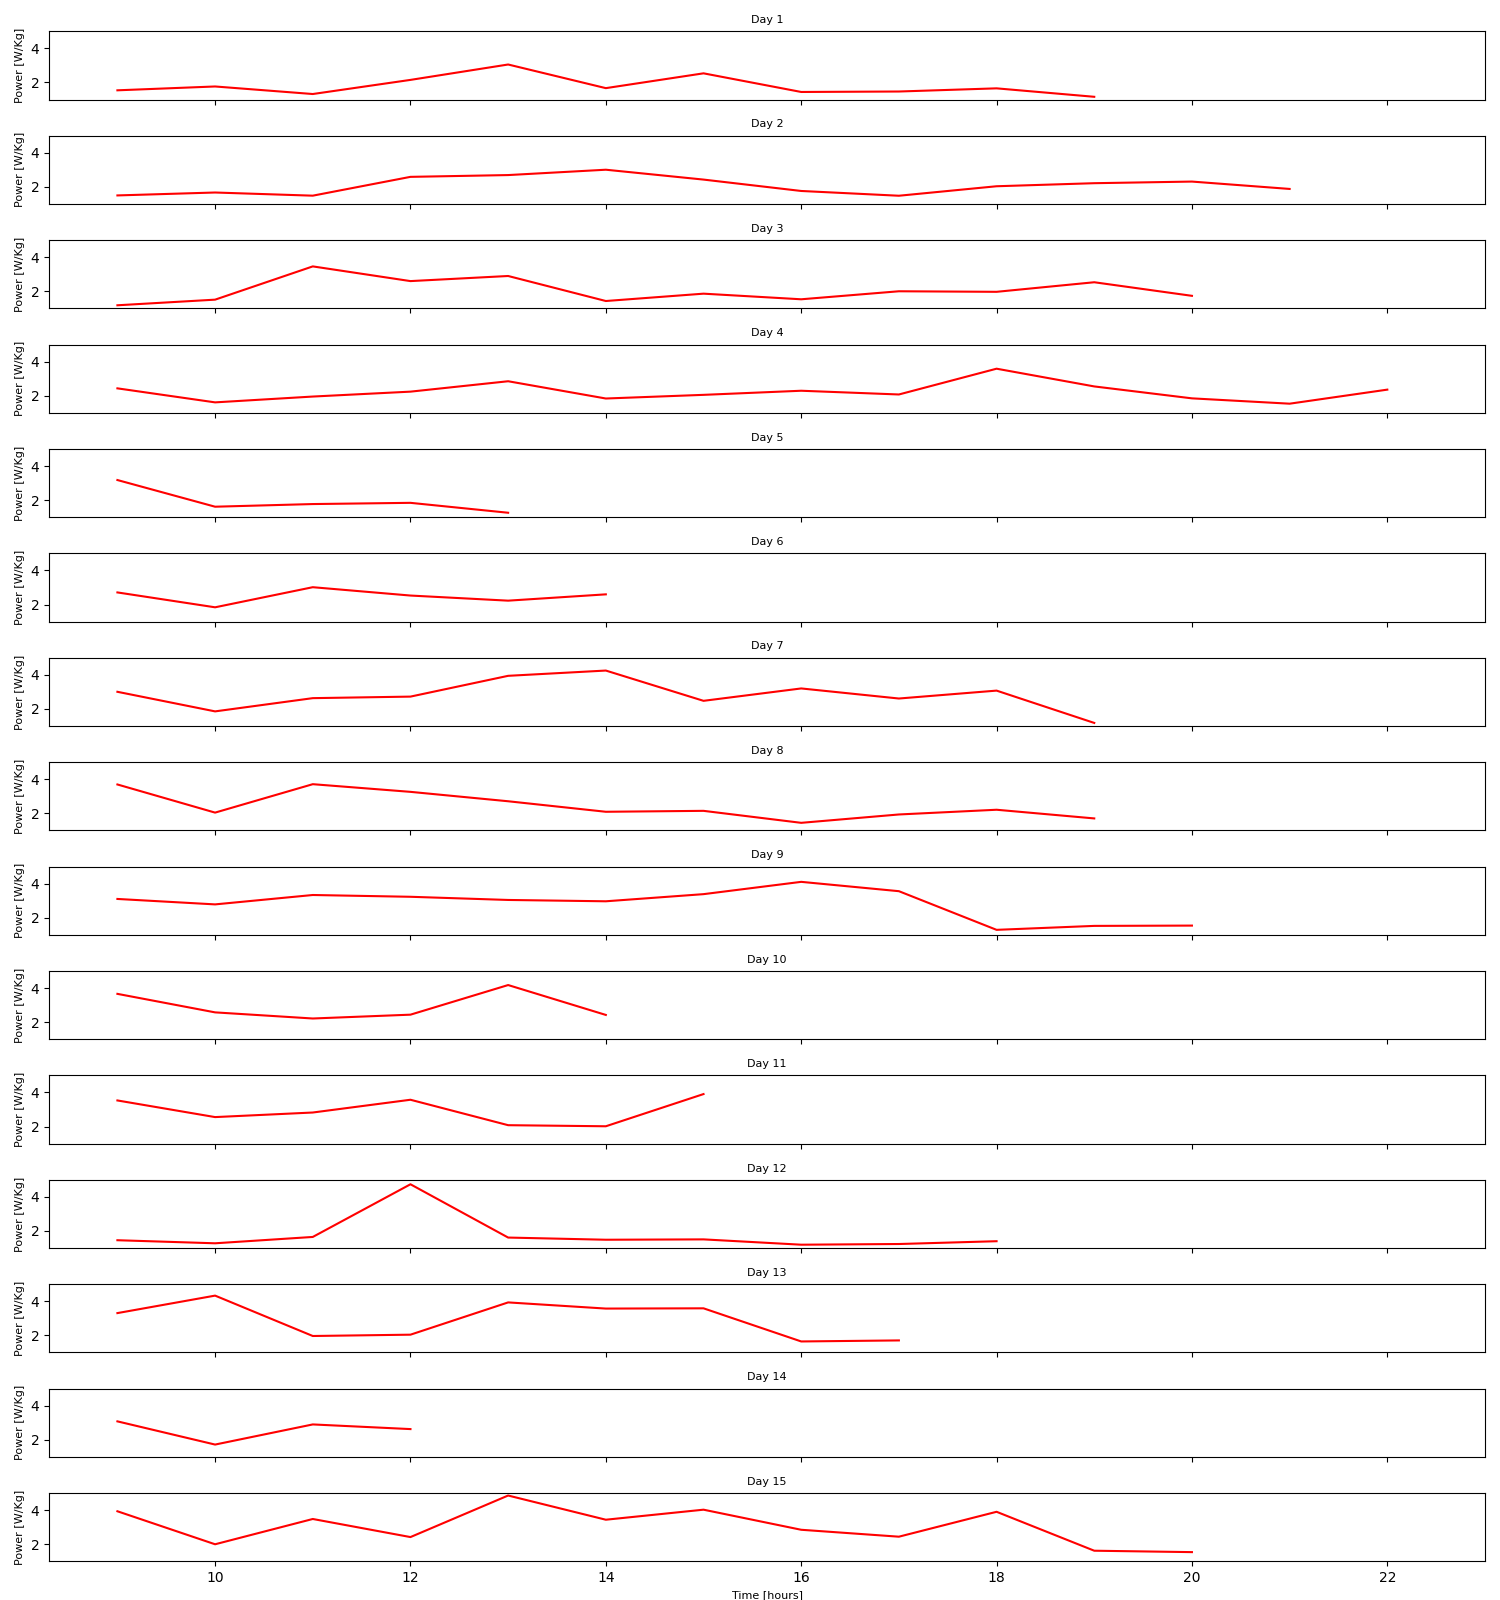

In [37]:
# Mean power of each hour of each day
fig_a,ax_1 = plt.subplots(len(days_power),1,figsize=(15,16),sharex=True)

for day_num in range(len(days_power)): # Iterating through each day 
    day_power = days_power[day_num]
    n=int(3600/day_time[1]) # number of points in one hour
    i=0
    sum_power_hours = np.zeros(int(len(day_power)/n)) # number of hours of each day
    for j in range(len(sum_power_hours)): #Iterating through each hour

        sum_power_hours[i] = day_power[j*n:n+(j*n)].sum()/( len(day_power[j*n:n+(j*n)])) # mean value 
        i=i+1
    # Graph    
        
    #ax_1 = fig_a.add_subplot(111)
    ax_1[day_num].plot((np.arange(9.0,len(sum_power_hours)+9)), sum_power_hours, color='r')
    ax_1[day_num].set_xlim([8.3, 23])
    ax_1[day_num].set_ylim([1, 5])
    ax_1[day_num].set_title('Day %i'%(day_num+1),fontsize=8)
    ax_1[day_num].set_ylabel('Power [W/Kg]', fontsize=8)
plt.tight_layout()
ax_1[day_num].set_xlabel('Time [hours]', fontsize=8)

Text(0, 0.5, 'Power [W/Kg]')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
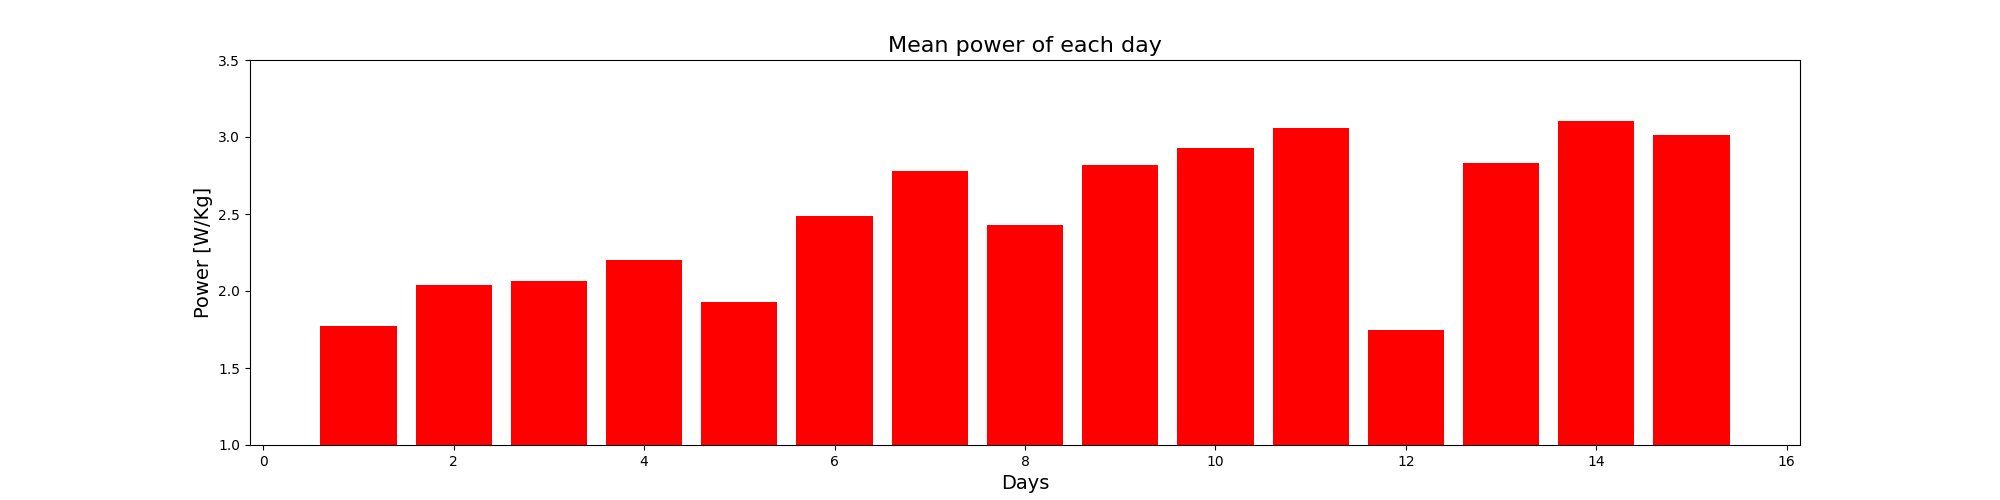

In [38]:
# Mean power of each day
plt.close('all')
sum_power_days = np.zeros(len(days_power))
for i in range(len(days_power)): # Iterating through each day 
    sum_power_days[i] = days_power[i].sum() / len( days_power[i]) # mean value 
# Graph
fig_a = plt.figure(figsize=(20,5))
ax_1 = fig_a.add_subplot(111)
ax_1.bar(range(1,len(days_power)+1), sum_power_days, color='r')
ax_1.set_ylim([1, 3.5])
ax_1.set_title('Mean power of each day',fontsize=16)
ax_1.set_xlabel('Days', fontsize=14)
ax_1.set_ylabel('Power [W/Kg]', fontsize=14)

Text(0, 0.5, 'Power [W/Kg]')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
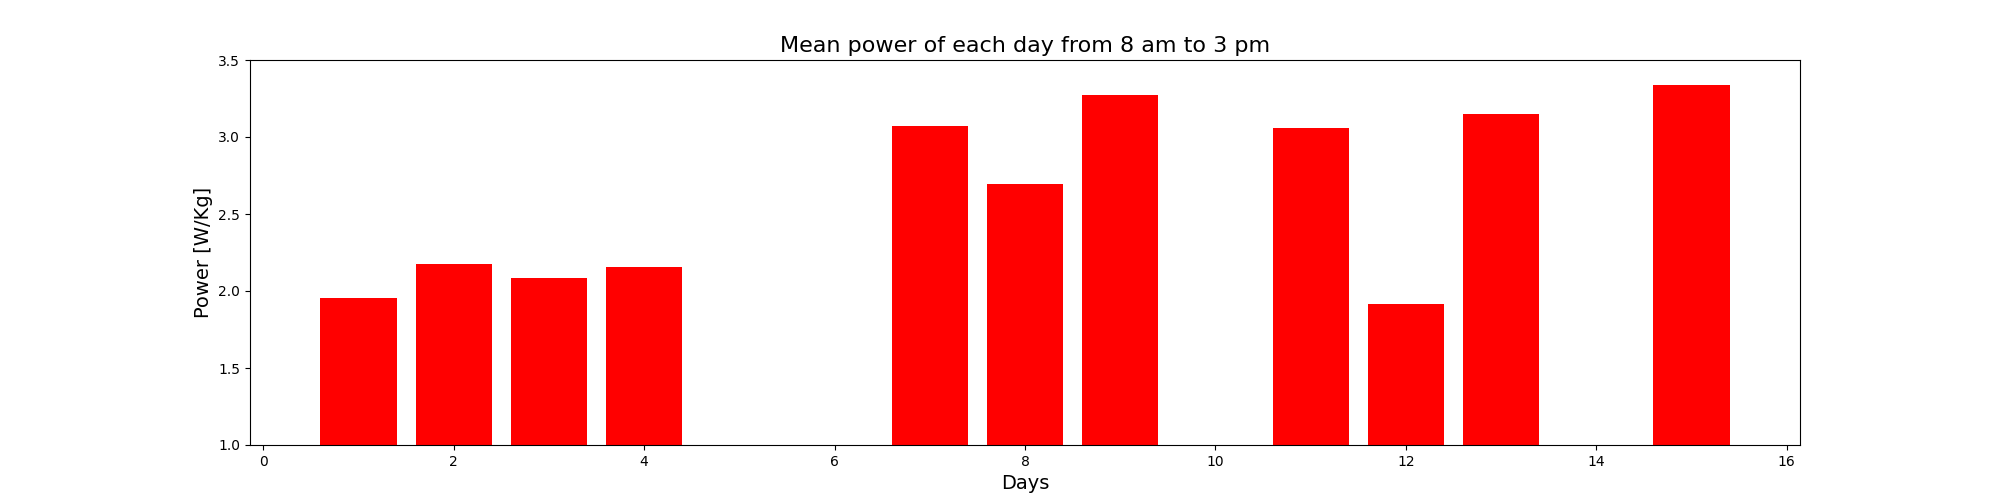

In [39]:
# Mean power of each day from 8 am to 3pm (days 5,6,10 and 14 removed).
plt.close('all')
sum_power_days = np.zeros(len(days_power))
for i in [0,1,2,3,6,7,8,10,11,12,14]: # Iterating through each day 
    sum_power_days[i] = days_power[i][0:len(days_power[10])].sum() / len( days_power[i][0:len( days_power[10] ) ] ) # mean value (from 8 am to 3 pm) 
fig_a = plt.figure(figsize=(20,5))
# graph
ax_1 = fig_a.add_subplot(111)
ax_1.bar(range(1,len(days_power)+1), sum_power_days, color='r')
ax_1.set_ylim([1, 3.5])
ax_1.set_title('Mean power of each day from 8 am to 3 pm',fontsize=16)
ax_1.set_xlabel('Days', fontsize=14)
ax_1.set_ylabel('Power [W/Kg]', fontsize=14)

Text(0, 0.5, 'Power [W/Kg]')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
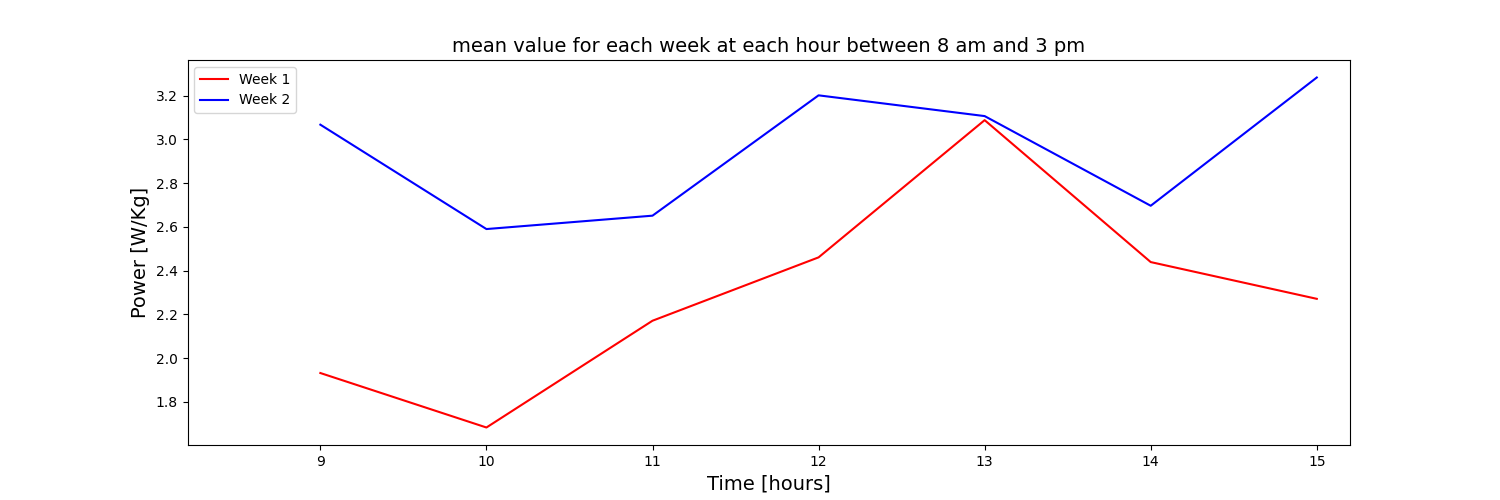

In [40]:
# Mean value for each week at each hour between 8 am and 3 pm.
plt.close('all')
sum_power_week2 = [0]
for day_num in [0,1,2,3,6,8,10,11,12,14]: # vector with the days that I am going to use. 
    day_power = days_power[day_num][0:len(days_power[10])]
    n=int(3600/day_time[1])
    i=0
    sum_power_hours = np.zeros(int(len(day_power)/n))
    for j in range(len(sum_power_hours)):
        sum_power_hours[i] = day_power[j*n:n+(j*n)].sum()/( len(day_power[j*n:n+(j*n)]))
        i=i+1
    # Condition to separate the two weeks
    if day_num ==8:
        sum_power_week1 =sum_power_week2
        sum_power_week2=[0] 
    # Adding the powers
    if len(sum_power_week2) < len(sum_power_hours):
        sum_power_hours[:len(sum_power_week2)] += sum_power_week2
        sum_power_week2=sum_power_hours
    else:
        sum_power_week2[:len(sum_power_hours)] += sum_power_hours    
# Graph
fig_a = plt.figure(figsize=(15,5))    
ax_1 = fig_a.add_subplot(111)
ax_1.plot((np.arange(9,len(sum_power_week1)+9)), sum_power_week1/5, color='r',label='Week 1')
ax_1.plot((np.arange(9,len(sum_power_week2)+9)), sum_power_week2/5, color='b',label='Week 2')
ax_1.legend(loc="upper left")
ax_1.set_xlim([8.2, 15.2])
ax_1.set_title('mean value for each week at each hour between 8 am and 3 pm',fontsize=14)
ax_1.set_xlabel('Time [hours]', fontsize=14)
ax_1.set_ylabel('Power [W/Kg]', fontsize=14)